# Effect of basis degree, penalty and knots

In [1]:
devtools::install("../../elasticproc2d", quiet=TRUE, quick=TRUE)

In [2]:
library(elasticproc2d)
library(ggplot2)
library(grid)
library(gridExtra)
library(dplyr)
library(cowplot)

# Display plots in smaller size
options(repr.plot.width=15, repr.plot.height=5)


Attaching package: 'dplyr'


The following object is masked from 'package:gridExtra':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




Load some datasets with random rotation and scaling.

In [3]:
source("../scripts/load_datasets.R")

set.seed(18)

spirals <- curves.spiral(n_curves=10, rotate=TRUE, scale=TRUE, center=FALSE)
digits3 <- curves.digit3(rotate=TRUE, scale=TRUE, center=FALSE)

Take a look at the data curves.

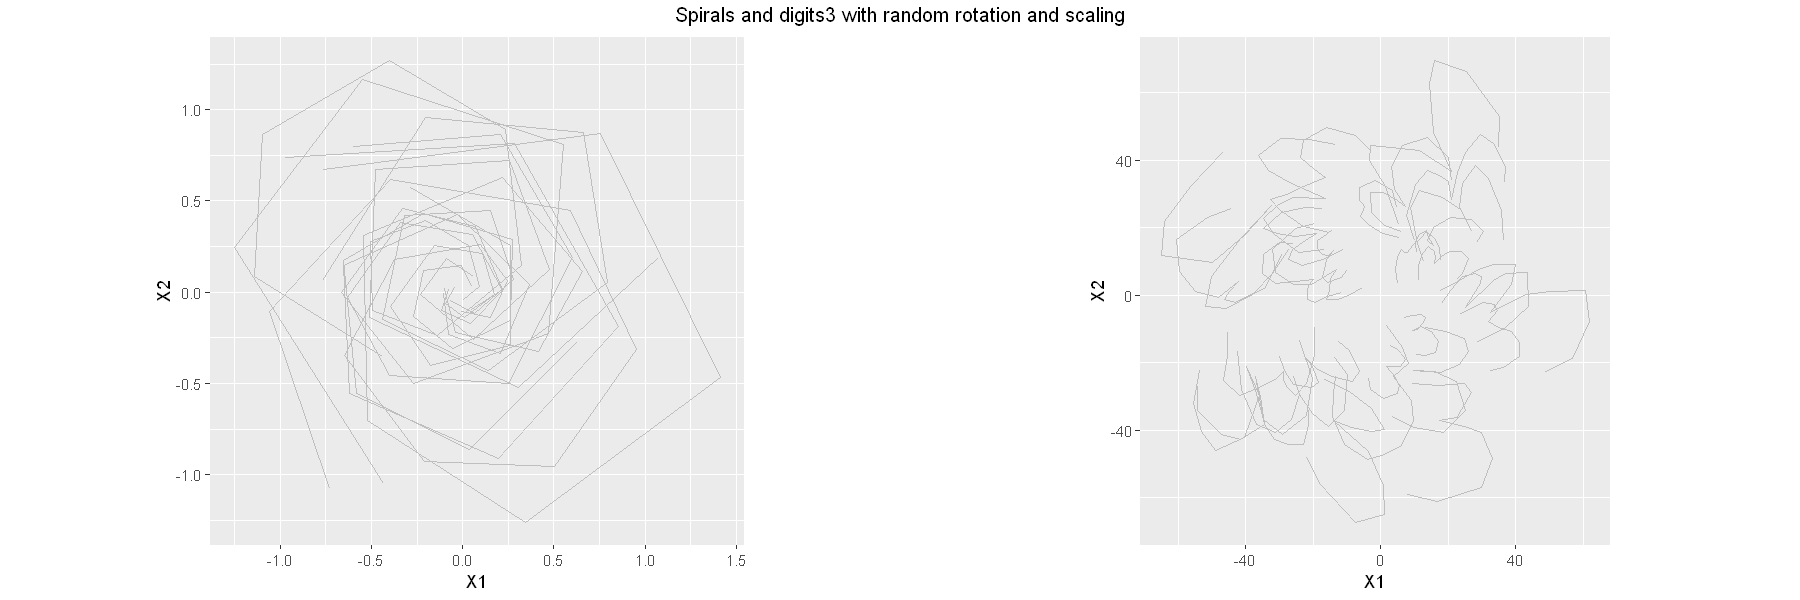

In [4]:
p1 <- ggplot(bind_rows(spirals, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey") +
    coord_fixed()

p2 <- ggplot(bind_rows(digits3, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey") +
    coord_fixed()

grid.arrange(p1, p2, nrow=1, top="Spirals and digits3 with random rotation and scaling")

Define functions for plotting.

In [5]:
plot_cov_surface<- function(cov_fit, h=0.01){
  # Define covariance surface grid (s,t).
  arg.grid = seq(0, 1, by=h)
  cov.grid = expand.grid(t = arg.grid, s = arg.grid)
  # Evaluate fit on grid.
  cov.re = predict(cov_fit$re, newdata = cov.grid)
  cov.im = predict(cov_fit$im, newdata = cov.grid)

  par(mfrow=c(1,2), mar=c(4,4,4,1), oma=c(0.5,0.5,0.5,0))
  # From 'fdapace/src/R/CreateCovPlot.R'
  args1 <- list(
    xlab='t', ylab='s', zlab = 'C(s,t)',
    main = 'Smoothed covariance surface (real part)'
  )
  args2 = list (x = arg.grid, y = arg.grid, z = matrix(cov.re, nrow=101))
  do.call(plot3D::persp3D, c(args2, args1))

  # From 'fdapace/src/R/CreateCovPlot.R'
  args1 <- list(
    xlab='t', ylab='s', zlab = 'C(s,t)',

    main = 'Smoothed covariance surface (imaginary part)'
  )
  args2 = list (x = arg.grid, y = arg.grid, z = matrix(cov.im,nrow=101))
  do.call(plot3D::persp3D, c(args2, args1))
}

library(grid)


plot_all <- function(mean, h=0.01){
    
  cov_fit <- mean$fit$cov_fit
  # Define covariance surface grid (s,t).
  arg.grid = seq(0, 1, by=h)
  cov.grid = expand.grid(t = arg.grid, s = arg.grid)
  # Evaluate fit on grid.
  cov.re = predict(cov_fit$re, newdata = cov.grid)
  cov.im = predict(cov_fit$im, newdata = cov.grid)

  par(mfrow=c(1,3), mar=c(4,4,4,1), oma=c(0.33,0.33,0.33,0))
 
  # From 'fdapace/src/R/CreateCovPlot.R'
  args1 <- list(
    xlab='t', ylab='s', zlab = 'C(s,t)',
    main = 'Smoothed covariance surface (real part)'
  )
  args2 = list (x = arg.grid, y = arg.grid, z = matrix(cov.re, nrow=101))
  do.call(plot3D::persp3D, c(args2, args1))

  # From 'fdapace/src/R/CreateCovPlot.R'
  args1 <- list(
    xlab='t', ylab='s', zlab = 'C(s,t)',

    main = 'Smoothed covariance surface (imaginary part)'
  )
  args2 = list (x = arg.grid, y = arg.grid, z = matrix(cov.im,nrow=101))
  do.call(plot3D::persp3D, c(args2, args1))

  plot(mean)
}

## Testing Parameters

In [6]:
order <- list("polygon", "smooth")
penalty <- list(0, 1, 2)
pfit_method <- "smooth"

In [7]:
# Turn of warnings
defaultW <- getOption("warn")
options(warn = -1)

## Spirals

In [8]:
spiral.means <- lapply(order, function(type){
    lapply(penalty, function(pen){
        start_time <- Sys.time()
        knots <- seq(0, 1, length = if_else(type == "smooth", 13, 19))
        print(paste0("Computing spirals mean:  Type = ", type, "  Penalty = ", pen, "  #Knots = ", length(knots)))
        flush.console()
        mean <- compute_elastic_proc2d_mean(spirals, knots = knots, type = type, penalty = pen, pfit_method = pfit_method)
        print(Sys.time() - start_time)
        flush.console()
        mean
    })
})

[1] "Computing spirals mean:  Type = polygon  Penalty = 0  #Knots = 19"
Time difference of 2.7101 mins
[1] "Computing spirals mean:  Type = polygon  Penalty = 1  #Knots = 19"
Time difference of 20.90091 secs
[1] "Computing spirals mean:  Type = polygon  Penalty = 2  #Knots = 19"
Time difference of 20.0103 secs
[1] "Computing spirals mean:  Type = smooth  Penalty = 0  #Knots = 13"
Time difference of 19.25245 secs
[1] "Computing spirals mean:  Type = smooth  Penalty = 1  #Knots = 13"
Time difference of 12.14113 secs
[1] "Computing spirals mean:  Type = smooth  Penalty = 2  #Knots = 13"
Time difference of 14.15717 secs


[1] "Type = polygon  Penalty = 0  #Knots = 19"


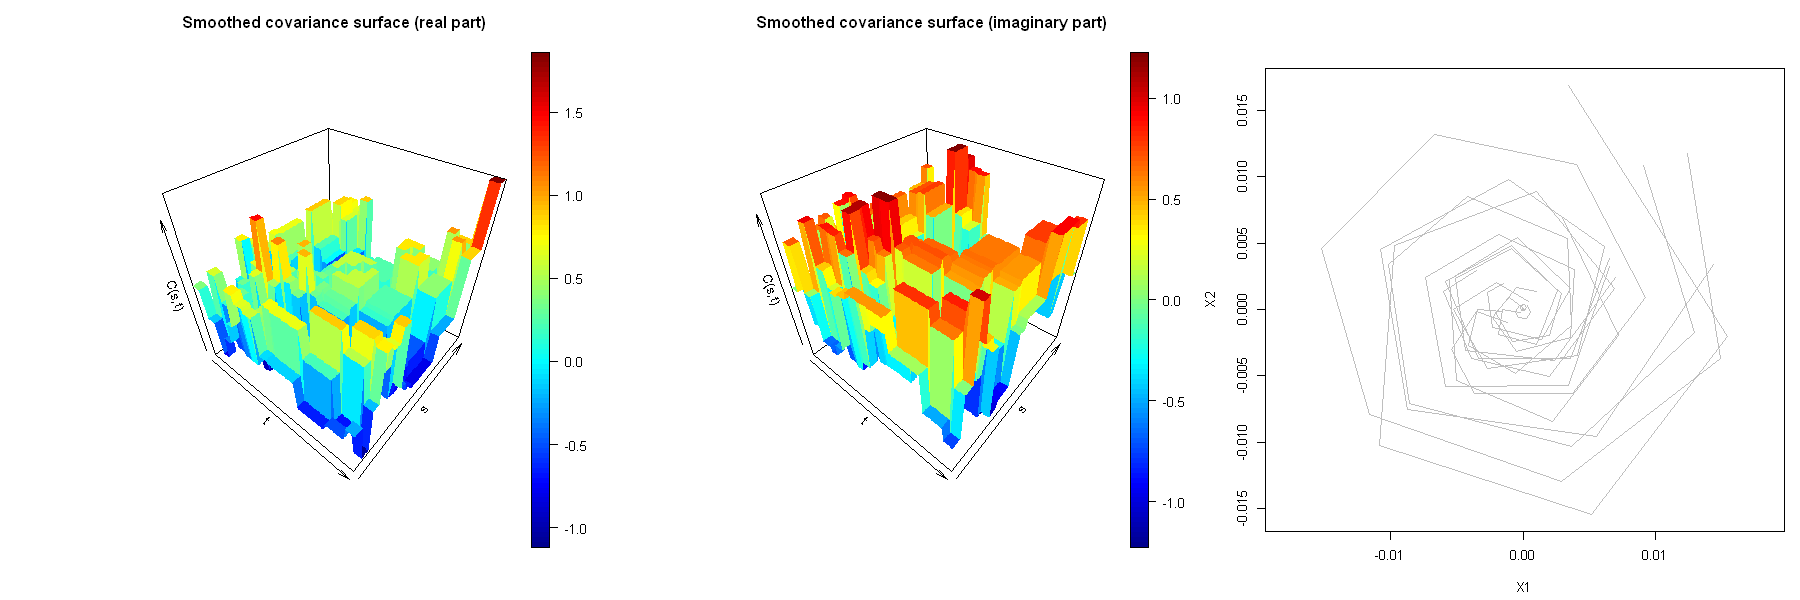

[1] "Type = polygon  Penalty = 1  #Knots = 19"


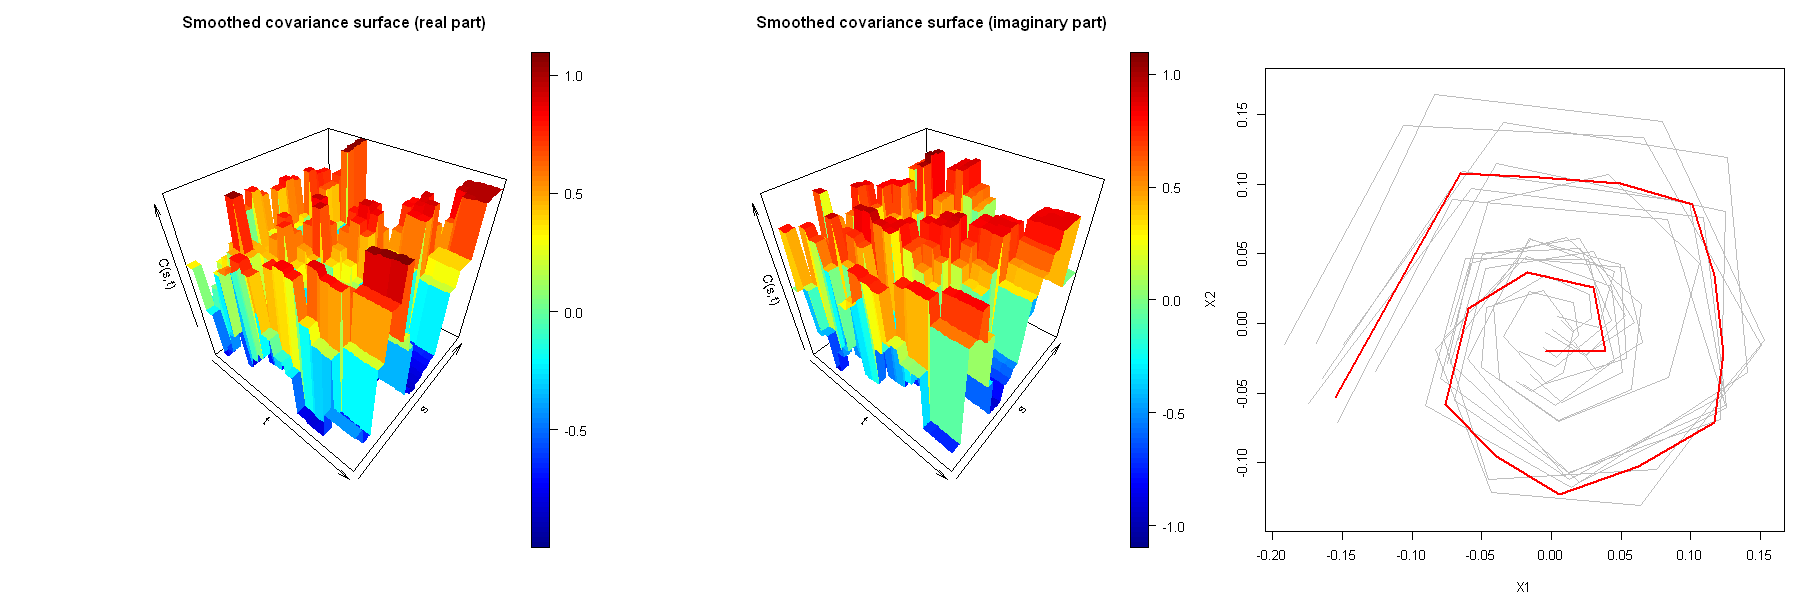

[1] "Type = polygon  Penalty = 2  #Knots = 19"


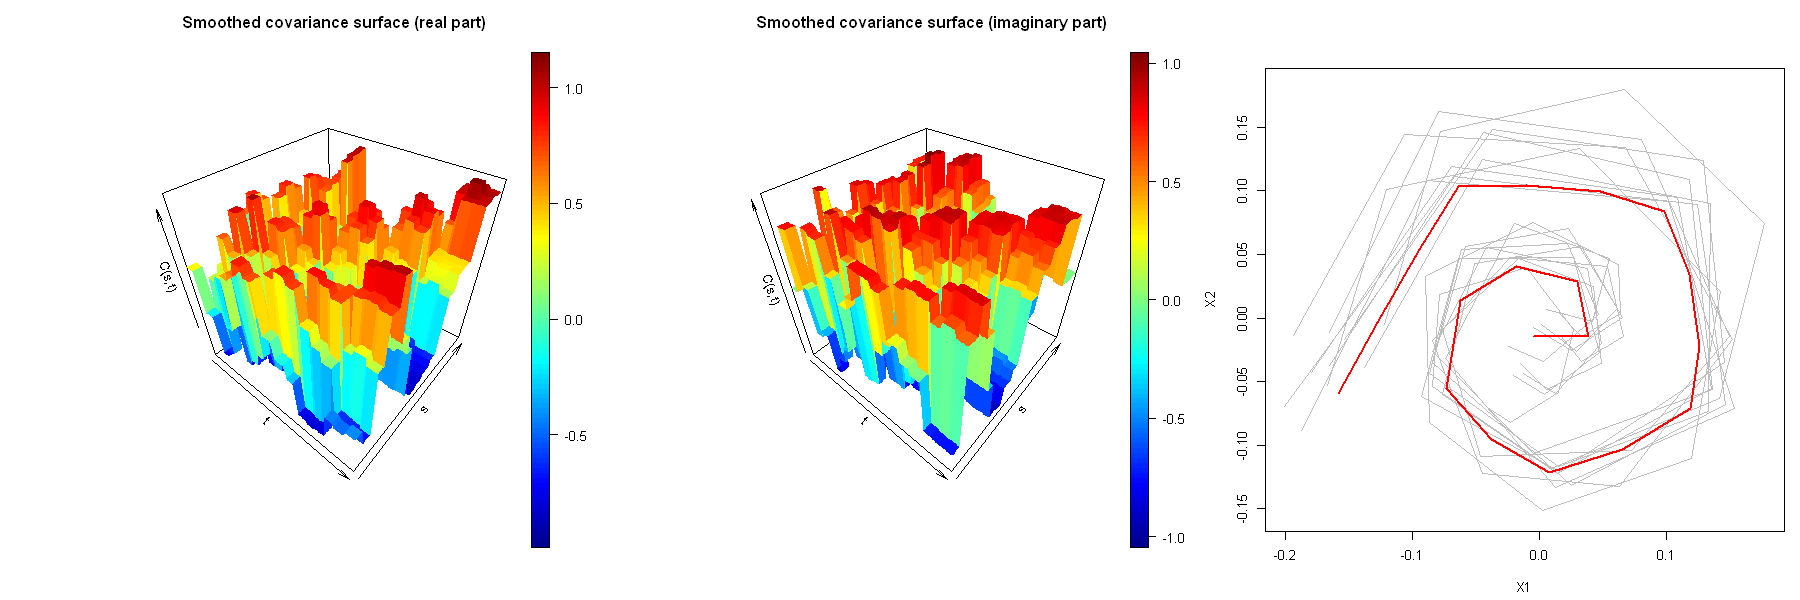

[1] "Type = smooth  Penalty = 0  #Knots = 13"


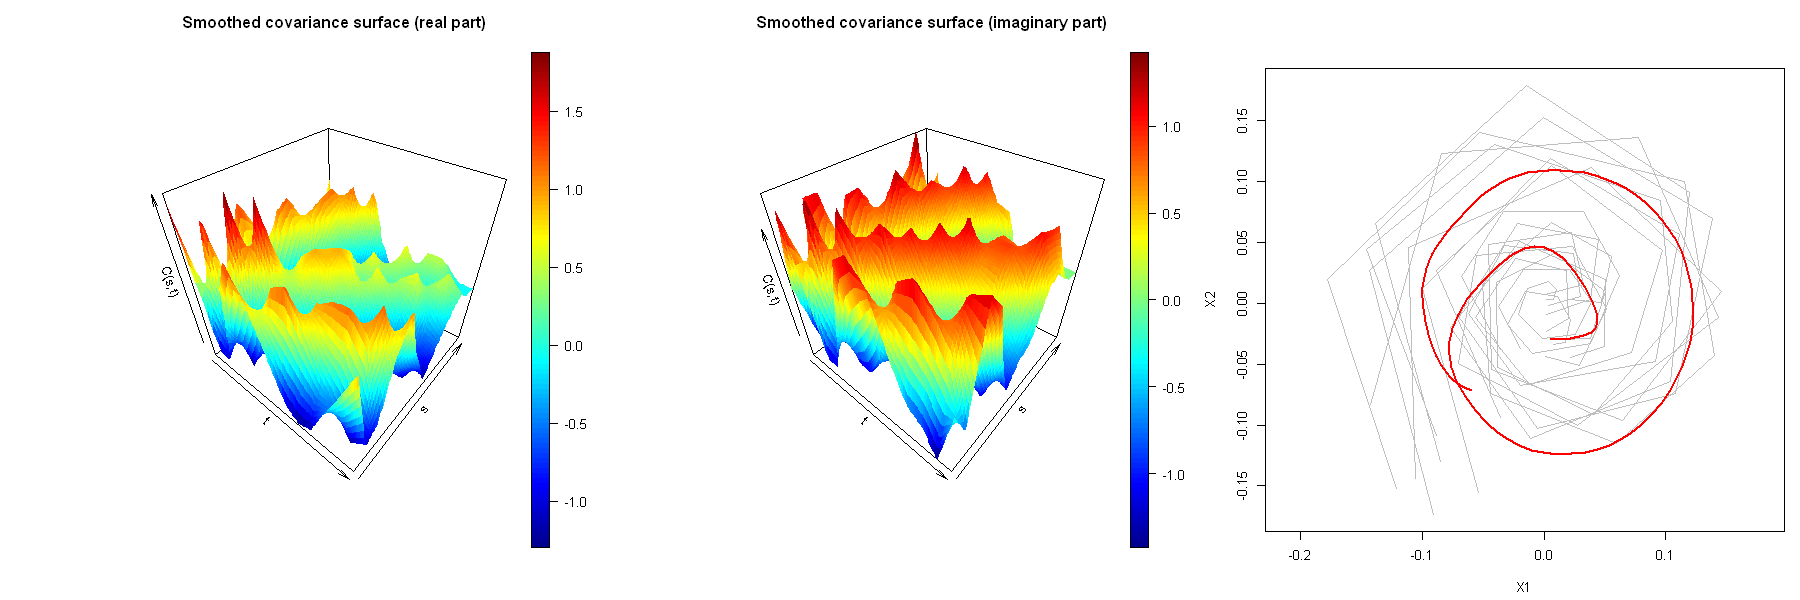

[1] "Type = smooth  Penalty = 1  #Knots = 13"


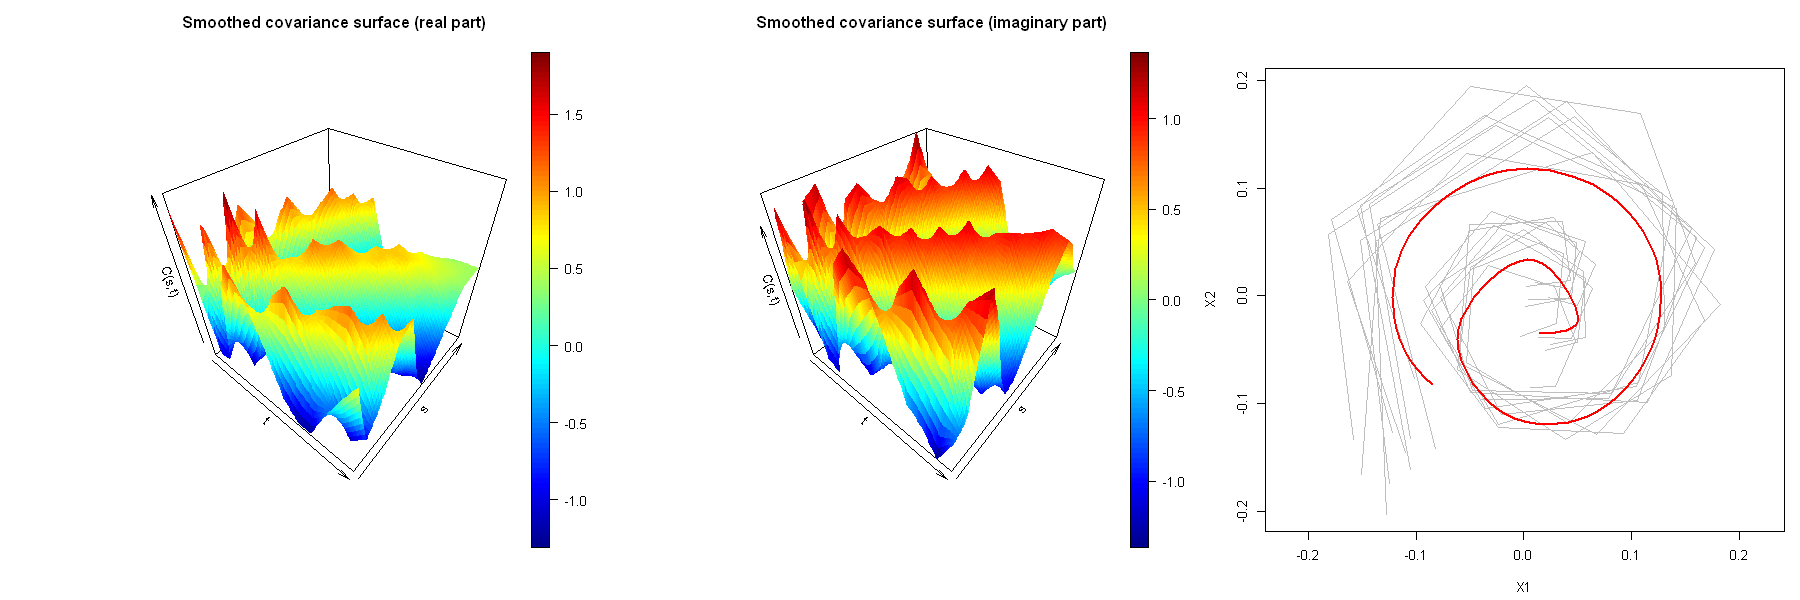

[1] "Type = smooth  Penalty = 2  #Knots = 13"


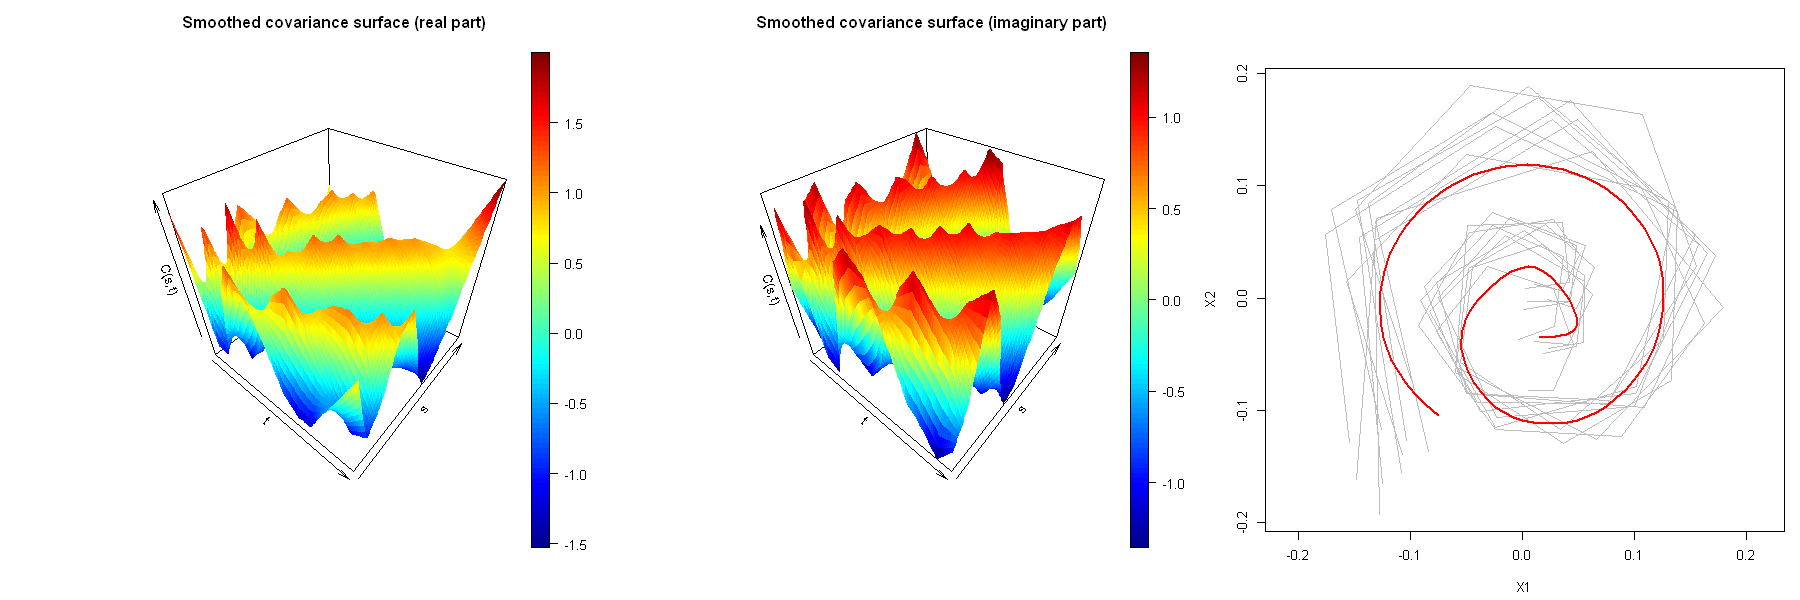

In [9]:
void <- lapply(1:length(order), function(i){
    lapply(1:length(penalty), function(j){
        mean <- spiral.means[[i]][[j]]
        plot_all(mean)
        print(paste0("Type = ", mean$type, "  Penalty = ", penalty[[j]], "  #Knots = ", length(mean$knots)))
    })
})

## Digits3

In [10]:
digits3.means <- lapply(order, function(type){
    lapply(penalty, function(pen){
        start_time <- Sys.time()
        knots <- seq(0, 1, length = if_else(type == "smooth", 13, 19))
        print(paste0("Computing digits3 mean:  Type = ", type, "  Penalty = ", pen, "  #Knots = ", length(knots)))
        flush.console()
        mean <- compute_elastic_proc2d_mean(digits3, knots = knots, type = type, penalty = pen, pfit_method = pfit_method)
        print(Sys.time() - start_time)
        flush.console()
        mean
    })
})

[1] "Computing digits3 mean:  Type = polygon  Penalty = 0  #Knots = 19"
Time difference of 22.69589 secs
[1] "Computing digits3 mean:  Type = polygon  Penalty = 1  #Knots = 19"
Time difference of 25.79453 secs
[1] "Computing digits3 mean:  Type = polygon  Penalty = 2  #Knots = 19"
Time difference of 24.44135 secs
[1] "Computing digits3 mean:  Type = smooth  Penalty = 0  #Knots = 13"
Time difference of 41.10031 secs
[1] "Computing digits3 mean:  Type = smooth  Penalty = 1  #Knots = 13"
Time difference of 30.28475 secs
[1] "Computing digits3 mean:  Type = smooth  Penalty = 2  #Knots = 13"
Time difference of 32.12973 secs


[1] "Type = polygon  Penalty = 0  #Knots = 19"


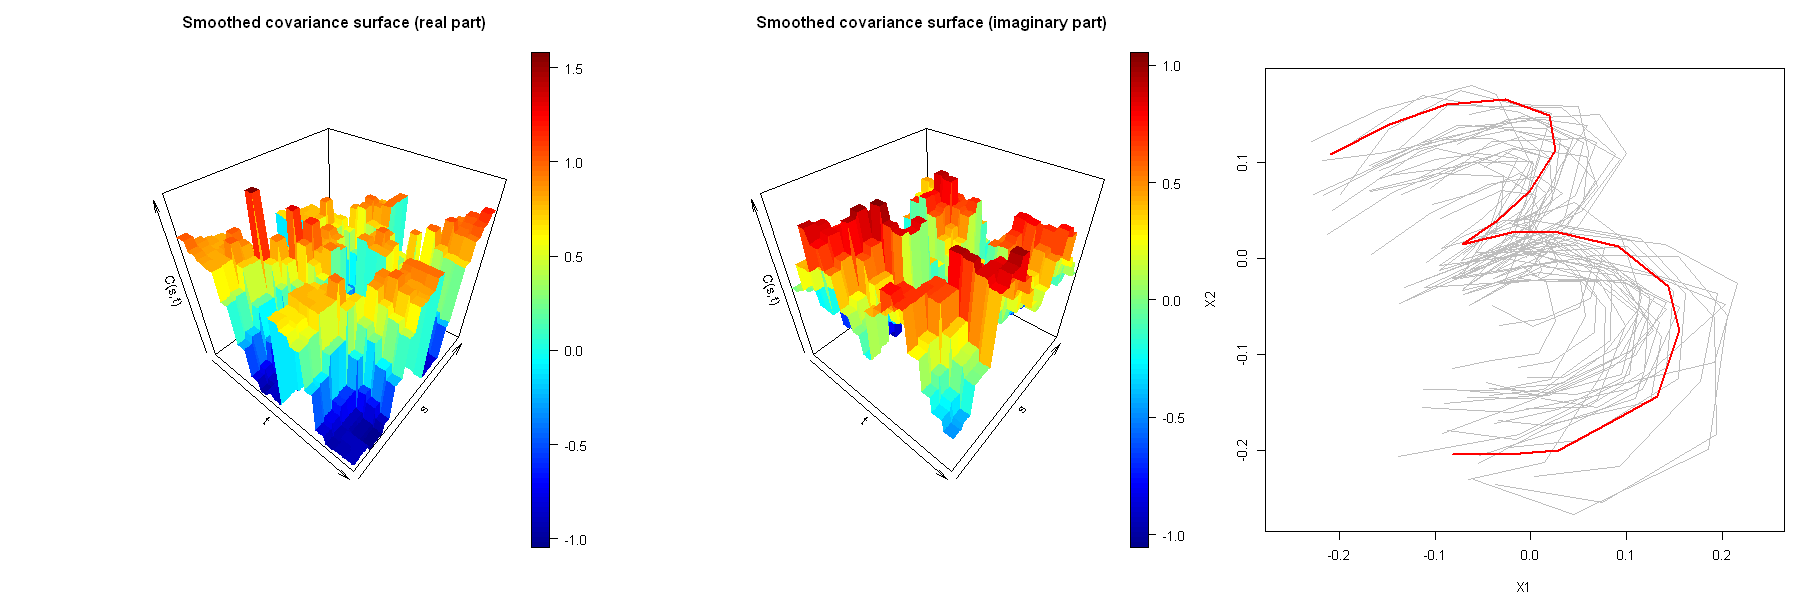

[1] "Type = polygon  Penalty = 1  #Knots = 19"


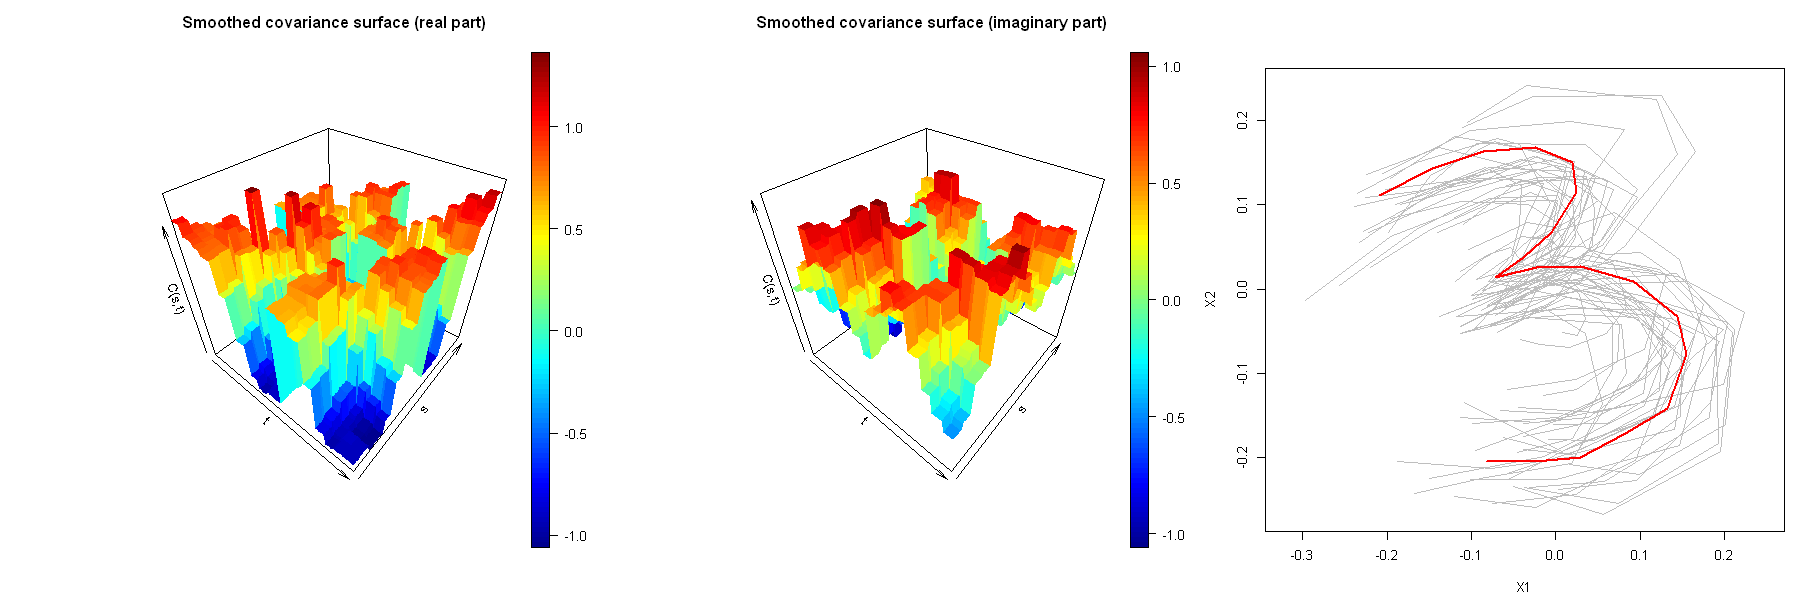

[1] "Type = polygon  Penalty = 2  #Knots = 19"


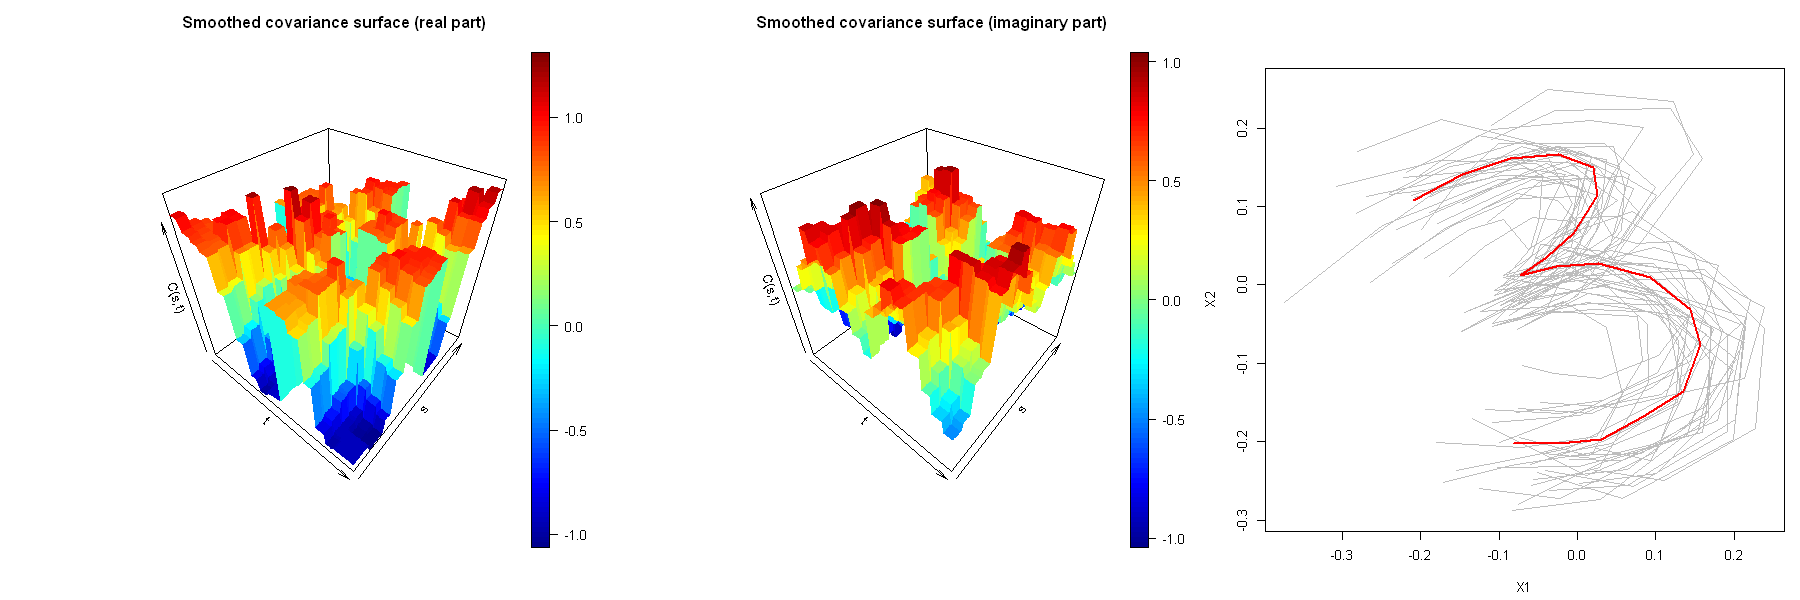

[1] "Type = smooth  Penalty = 0  #Knots = 13"


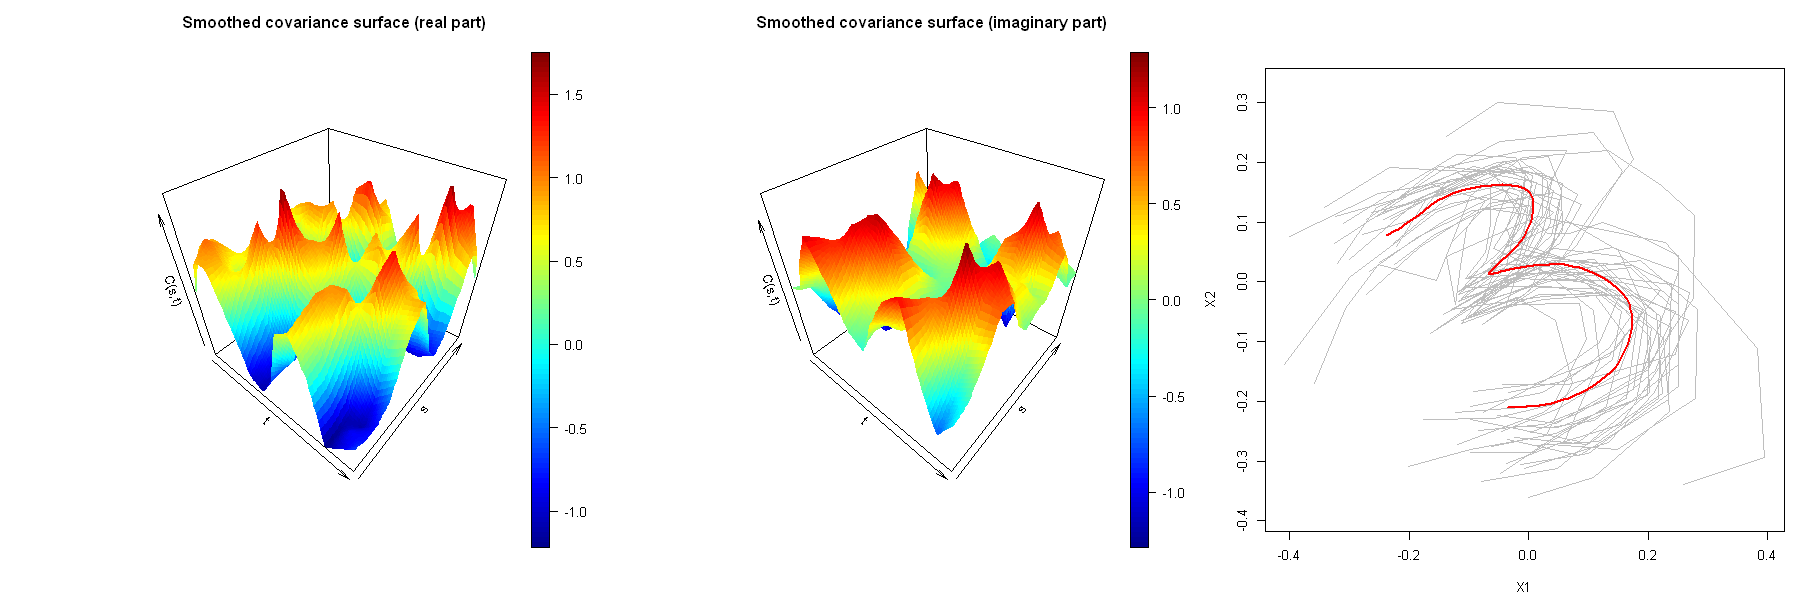

[1] "Type = smooth  Penalty = 1  #Knots = 13"


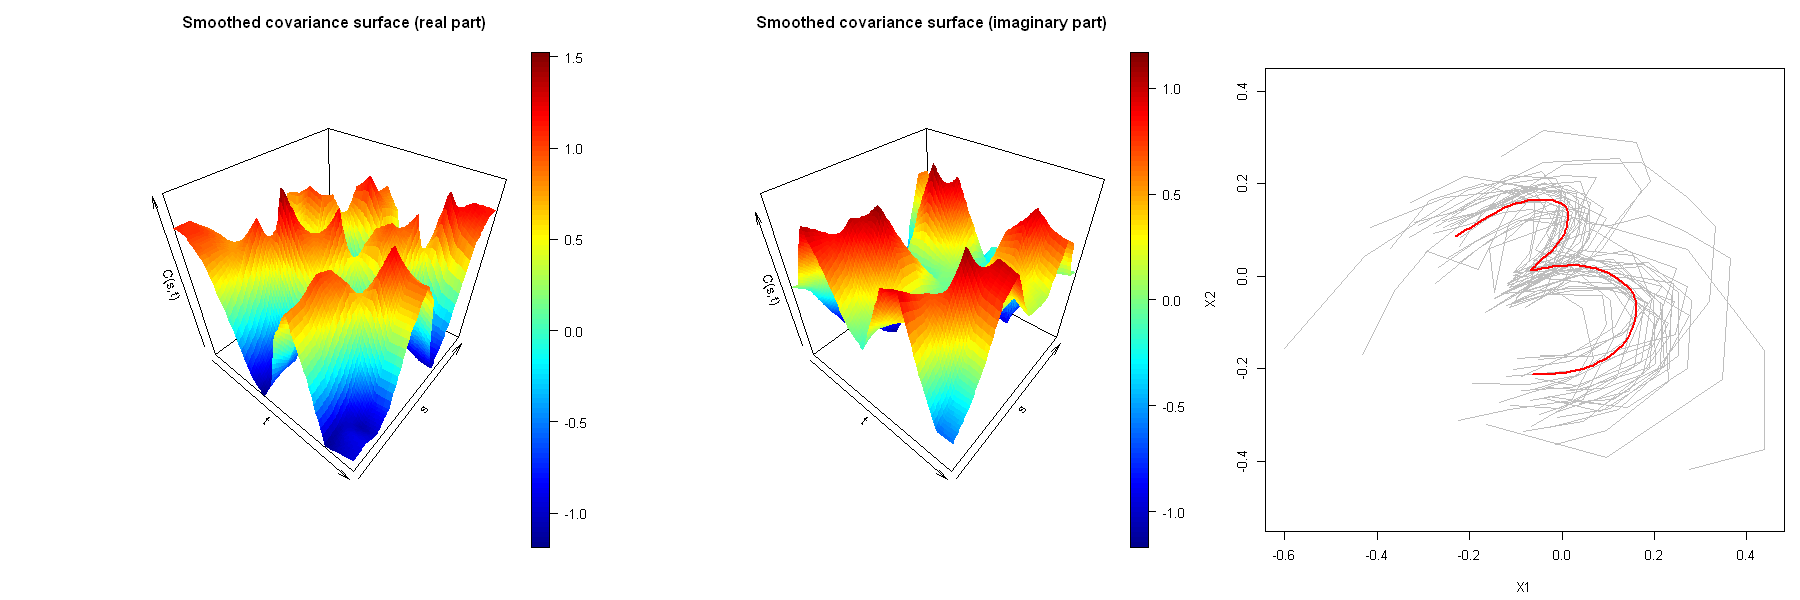

[1] "Type = smooth  Penalty = 2  #Knots = 13"


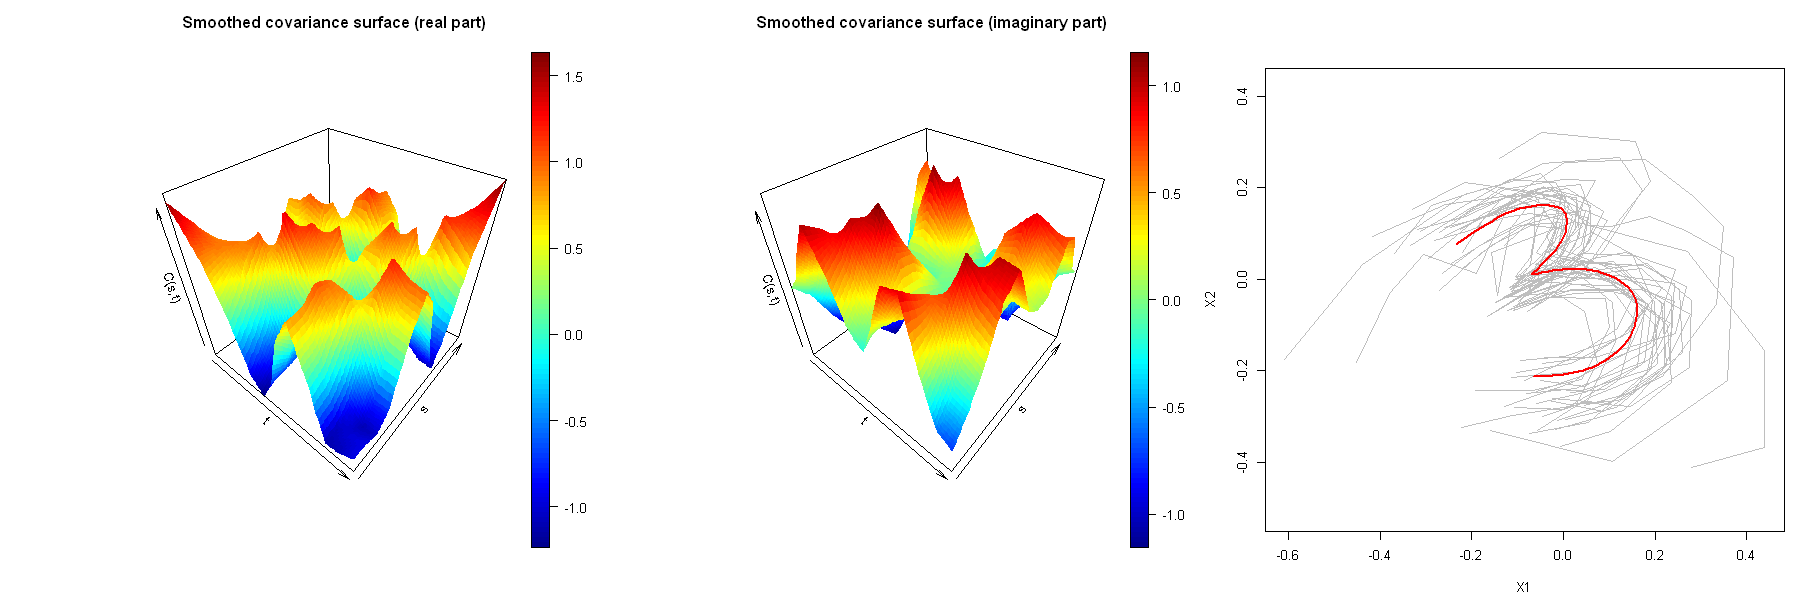

In [11]:
void <- lapply(1:length(order), function(i){
    lapply(1:length(penalty), function(j){
        mean <- digits3.means[[i]][[j]]
        plot_all(mean)
        print(paste0("Type = ", mean$type, "  Penalty = ", penalty[[j]], "  #Knots = ", length(mean$knots)))
    })
})

## No penalty

In [12]:
mean.sp.nofx.poly <- compute_elastic_proc2d_mean(spirals, knots = seq(0,1,length=15), type = "polygon", penalty = -1)
mean.sp.nofx.smooth <- compute_elastic_proc2d_mean(spirals, knots = seq(0,1,length=11), type = "smooth", penalty = -1)

In [13]:
mean.d3.nofx.poly <- compute_elastic_proc2d_mean(digits3, knots = seq(0,1,length=15), type = "polygon", penalty = -1)
mean.d3.nofx.smooth <- compute_elastic_proc2d_mean(digits3, knots = seq(0,1,length=11), type = "smooth", penalty = -1)

Plots

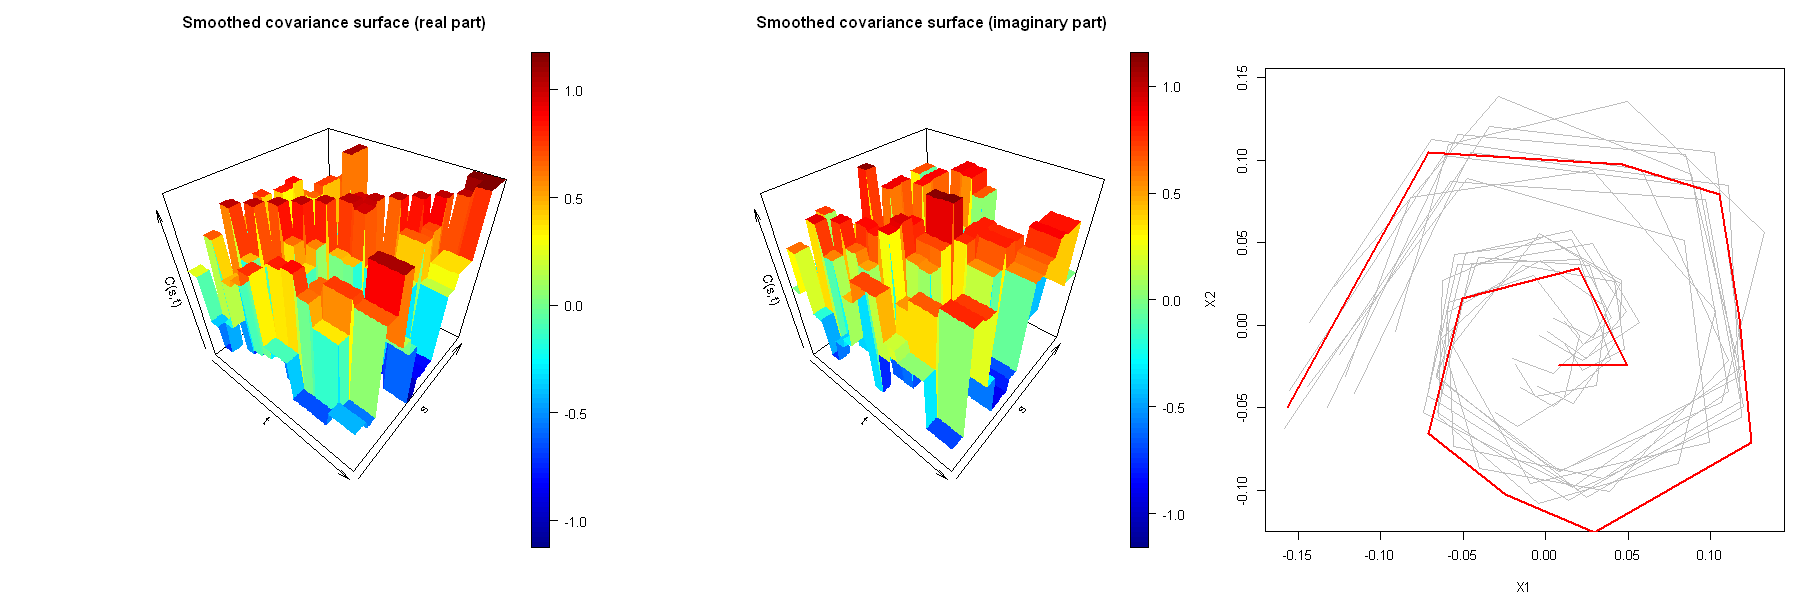

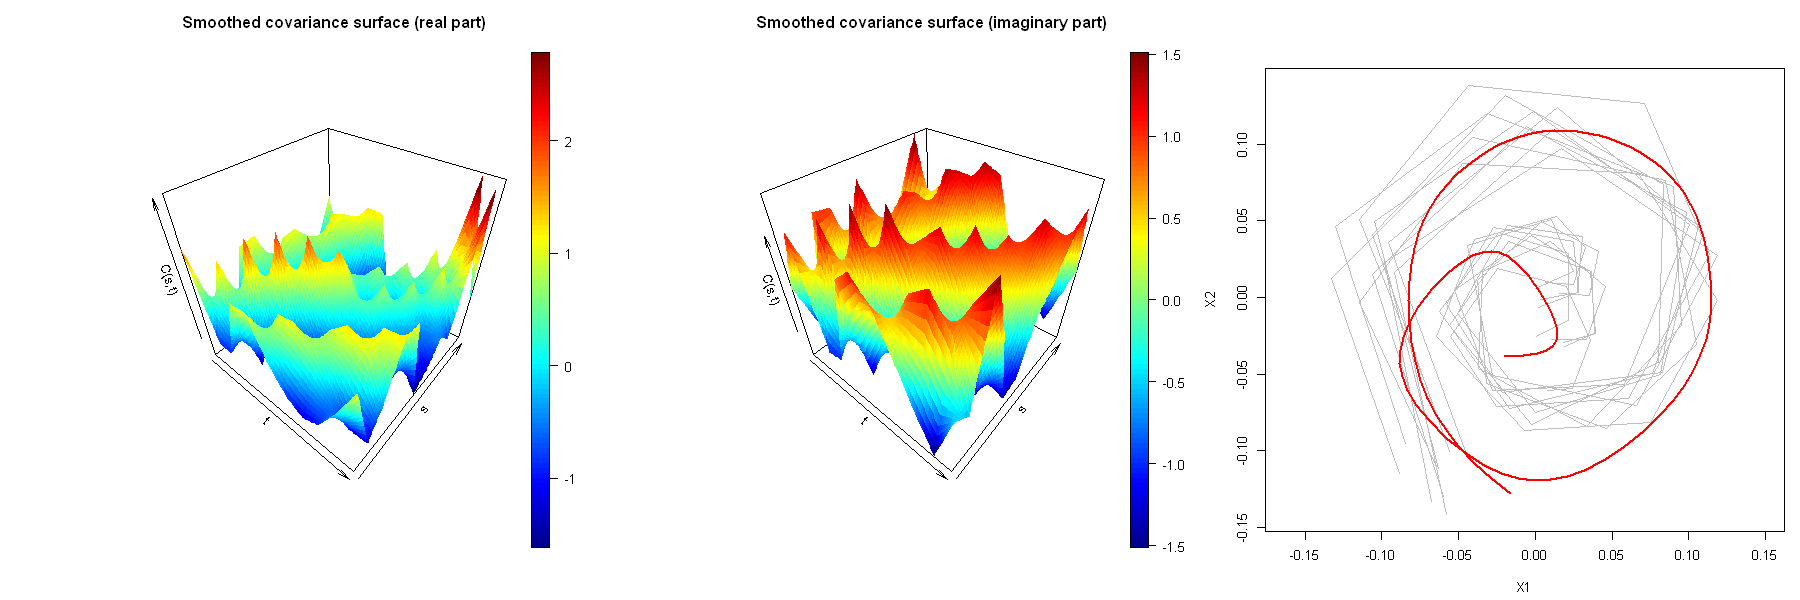

In [14]:
plot_all(mean.sp.nofx.poly)
plot_all(mean.sp.nofx.smooth)

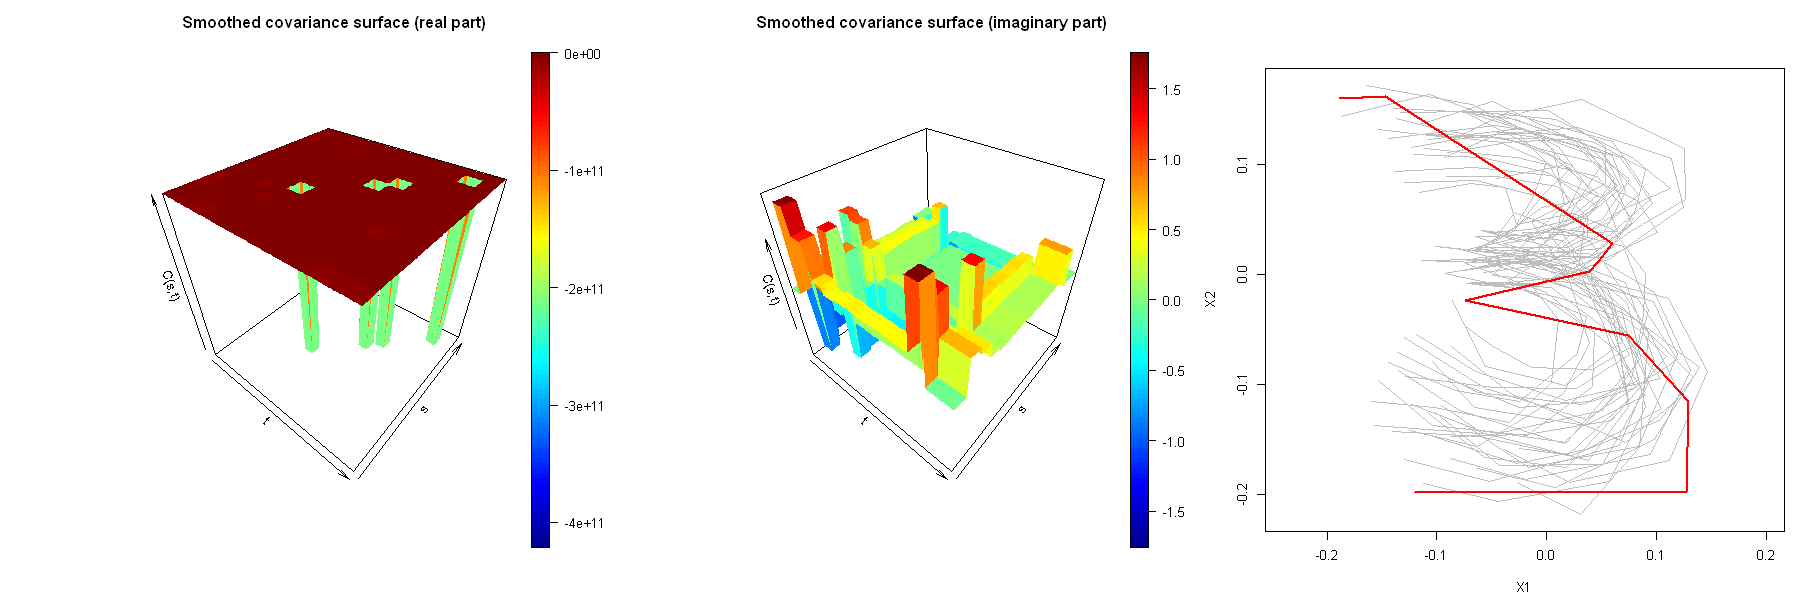

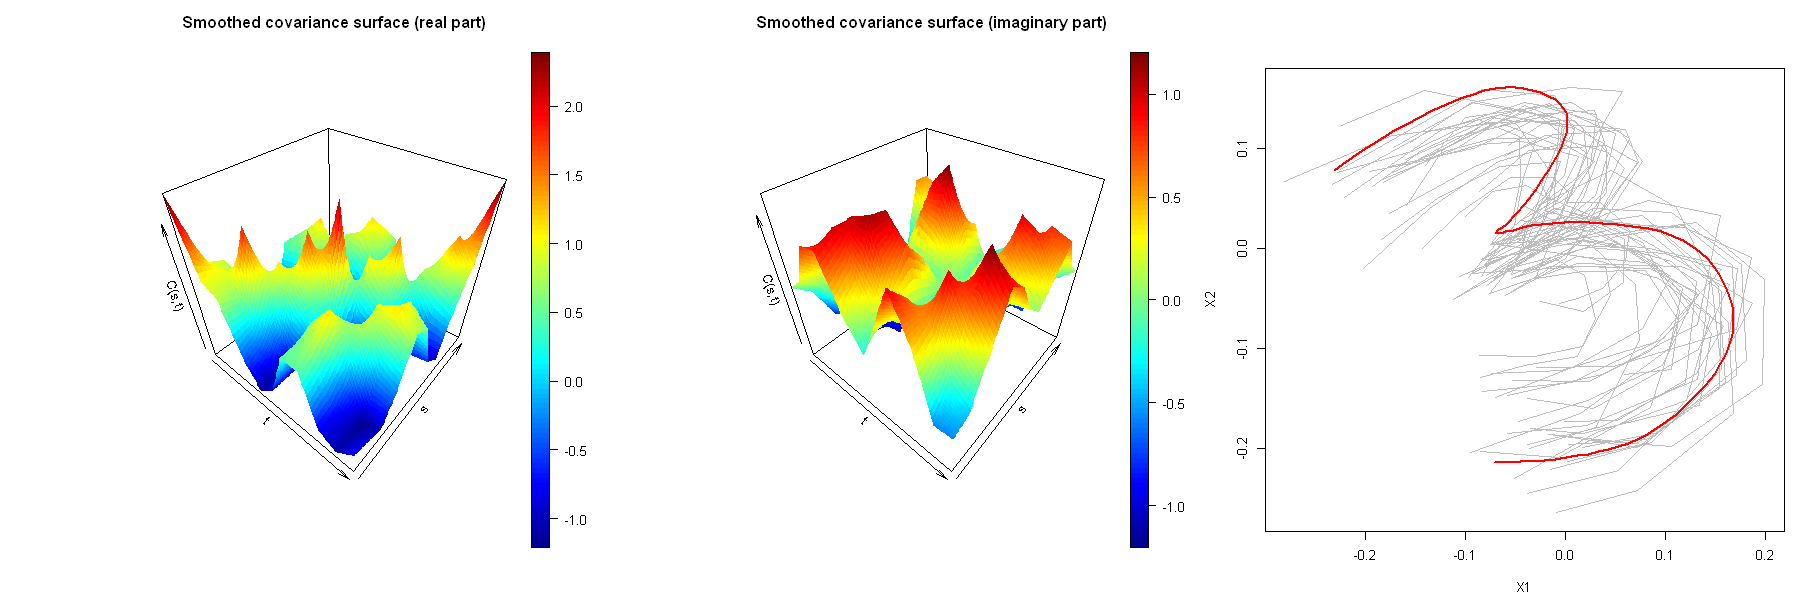

In [15]:
plot_all(mean.d3.nofx.poly)
plot_all(mean.d3.nofx.smooth)